# Using burn-in period

In [11]:
import numpy as np
import matplotlib.pylab as plt

import itertools
import pandas as pd

import sys
sys.path.append('../src/')
import solve_kolmogorov
import simulate_gillespie
import Hypergraphs

from scipy.integrate import solve_ivp

from scipy.special import comb

In [12]:
"""Complete case test."""
# setup
nsims = 10 # number of simulation runs
time_max = 10   # maximum time duration


N = 100
g = Hypergraphs.CompleteHypergraph(N)

I0 = 10 # number of initial infected
initial_infections = list(range(I0)) # which nodes are infected at t=0 doesn't matter

beta1 = 2 / N       # pairwise infection rate
beta2 = 4 / (N**2)  # hyperedge contagion rate
mu    = 1           # recovery rate

print(f"Setup: \n")
print(f"\tH = {g.__class__.__name__}, N = {N}, I0 = {I0}\n")
print(f"\tbeta1 = {beta1}, beta2 = {beta2}, mu = {mu}\n")

Setup: 

	H = CompleteHypergraph, N = 100, I0 = 10

	beta1 = 0.02, beta2 = 0.0004, mu = 1



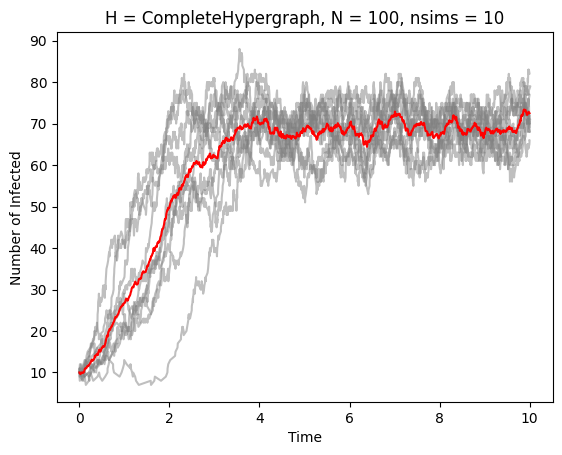

In [14]:
# plot X_t curves in gray and average curve in red
fig = plt.figure()
ax  = plt.subplot()
for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="gray", alpha=0.5)
avg_curve, times = simulate_gillespie.get_average(X_sims, time_max, nsims, delta_t = 0.01)
plt.plot(times, avg_curve, "red")
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}")
# plt.savefig("../figures/solutions-kolmogorov/complete/gillespie-sims.pdf", 
#             format='pdf', bbox_inches='tight')
plt.show()

In [15]:
# solve KEs and compare
all_states = solve_kolmogorov.list_all_states(g)
M = len(all_states)
ode_system_complete = solve_kolmogorov.list_all_ODEs_complete(g, beta1, beta2, mu)

# set the initial condition
p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0

# solve ode_system_complete over time
# e.g. from 0 to 10
t_span = (0.0, 10.0)

# times t_i to evaluate in, get saved in sol.t
t_eval = np.linspace(t_span[0], t_span[1], 101)

def f_ode(t, p):
    return ode_system_complete(t, p)

sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="RK45"
)

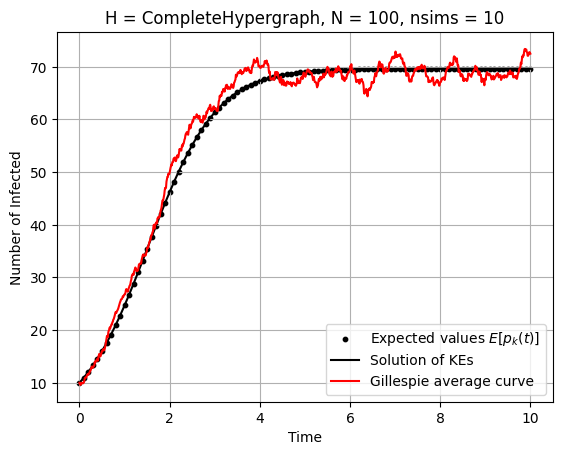

In [ ]:
# plot both the expected values of p_{k}(t) 
# and the Gillespie average curve
# on the same figure

expected_values = solve_kolmogorov.calculate_expected_values(sol)

plt.figure()
plt.scatter(sol.t, expected_values, s = 10, color="k", 
            label=r"Expected values $E[p_{k}(t)]$")
plt.plot(sol.t, expected_values, color="k",
            label="Solution of KEs")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve")
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}")
# TODO: export the plot
# plt.savefig("../figures/solutions-kolmogorov/complete/solution-vs-gillespie-avg.pdf", 
#             format='pdf', bbox_inches='tight') 
plt.show()

## Using burn-in
Start with I0=10 and then only conider the time and number onfected from wwhen we observe 20 cases

In [18]:
threshold = 20.0

times = np.asarray(times)
avg_curve = np.asarray(avg_curve)
expected_values = np.asarray(expected_values)

indices_above_threshold = np.where(avg_curve >= threshold)[0]

In [19]:
len(indices_above_threshold)

935

In [20]:
first_index_above_threshold = indices_above_threshold[0]

start_time = times[first_index_above_threshold]
print(f"Threshold {threshold} reached at time: {start_time:.4f}")

Threshold 20.0 reached at time: 0.6600


In [21]:
# filter and shift time axis at time point where threshold is reached
gillespie_mask = times >= start_time
filtered_times_gillespie = times[gillespie_mask]
filtered_avg_curve = avg_curve[gillespie_mask]

shifted_times_gillespie = filtered_times_gillespie - start_time

In [22]:
# filter also Kolmogorov solution
# keep only points from start_time onwards
ke_mask = sol.t >= start_time
filtered_times_ke = sol.t[ke_mask]
filtered_expected_values = expected_values[ke_mask]

shifted_times_ke = filtered_times_ke - start_time

In [ ]:
# plot shifted Gillespie average
plt.plot(shifted_times_gillespie, filtered_avg_curve, 'red',
            label="Gillespie average curve")


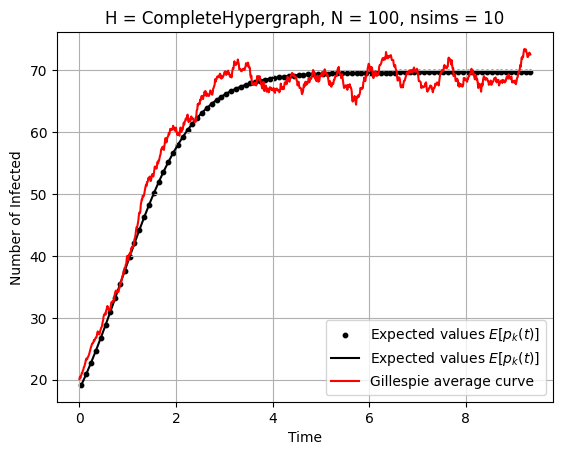

In [ ]:
# plot both the expected values of p_{k}(t) 
# and the Gillespie average curve
# on the same figure

expected_values = solve_kolmogorov.calculate_expected_values(sol)

plt.figure()
plt.scatter(shifted_times_ke, filtered_expected_values, s = 10, color="k", 
            label=r"Expected values $E[p_{k}(t)]$")
plt.plot(shifted_times_ke, filtered_expected_values, color="k",
            label=r"Expected values $E[p_{k}(t)]$")

plt.plot(shifted_times_gillespie, filtered_avg_curve, 'red', label="Gillespie average curve")
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}")
# TODO: export the plot
# plt.savefig("../figures/solutions-kolmogorov/complete/solution-vs-gillespie-avg.pdf", 
#             format='pdf', bbox_inches='tight') 
plt.show()